# High potential regions for E-Commerce by population and retail density
by Kevin Götz

## Table of Contents

1. **Introduction & Relevance**

2. Import **Libraries**

3. **Webscraping** zipcode data for Germany

    - 3.1 Scraping the URLs for the regional pages of Germany

    - 3.2 Scraping the regional pages for zipcode information

4. **Webscraping** Wikipedia

    - 4.1 Scraping, parsing & cleaning the Wikipedia search results for single zipcodes and city information

    - 4.2 Scraping & parsing the most relevant (as defined by wikipedia algorithm) search results

    - 4.3 Rescraping & Cleaning missing or wrong information with adapted approach

5. **Geocoder API**: Adding Coordinates

6. **Data Quality Assessment & Data Cleaning**

7. **Foursquare API**: Adding Retail Store Information

    - 7.1 Collecting API Information

    - 7.2 Data Cleaning

8. **Benchmarking the Neighborhoods**

    - 8.1 Joining the Data 

    - 8.2 Feature Engineering population density, retail density and potential

    - 8.3 Visualizing the high potential regions

9. **Discussion & Outlook**

## 1. Introduction & Relevance
**Background:**

COVID-19 has led to a surge in e-commerce and accelerated digital transformation. As closures became the new normal, consumers and businesses have become increasingly "digital," offering and buying more goods and services online.

** Problem for E-Commerce:**

Some changes in consumers' shopping habits may be longer-lasting, but there may be several push and pull factors for consumers to leave their house again for an in-person shopping experience offline. After more than one year living in a lockdown the consumers probably are looking forward to experience the normal every day life again and not sit in their flats in front of their screens (push factors). Also, the retail shops are probably offering widespread sales campaigns to attract potential customers and drive revenue again to counteract the lost year of commerce (pull factor).
With the lifting of the restrictions in germany the e-commerce companies no longer have the “monopoly” on shopping and the competition gets more balanced again. The e-commerce industry needs to find strategies to keep up the momentum and not lose their newly gained customers.

** Objective of this Project:**

A possible lever for customer retention and customer acquisition could be a geographical analysis of the retail landscape and population. Assuming that consumers with sparse shopping options in their area are more likely to order online, this project aims to find regions within Germany that have a high population density as well as a low retail density. If a e-commerce company is focusing their marketing strategies towards those regions it may uplift their ROI.

## 2. Import Libraries

In [2]:
# Data Munging
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np 
import re
from sklearn.preprocessing import MinMaxScaler

# System
from time import sleep
from datetime import datetime, timedelta
import sys
import json

# Webscraping
import requests
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as bs

# Visualization
from pprint import pprint
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
%matplotlib inline

# Geocoding
import geocoder

## 3. Webscraping zipcode data for Germany
Getting an up-to-date and clean list of german postal codes with information on city, quarter, district and region

### 3.1 Scraping the URLs for the regional pages of Germany
The zipcodes are webscraped from the german website 'https://home.meinestadt.de' because it has the most detailed and clean zipcodes for germany compared to other pages like 'https://en.wikipedia.org/wiki/List_of_postal_codes_in_Germany' (not detailed enough) or 'https://worldpostalcode.com/germany/' (not clean enough).

In [2]:
# define website and headers for HTTP Client, so the Scraper doesn't get blocked vis 403 HTTP Error
website = 'https://home.meinestadt.de/deutschland/postleitzahlen'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)'}
req = Request(url=website, headers=headers) 
html_germany = urlopen(req).read()

In [3]:
# parse the html for regions info
soup_germany = bs(html_germany, 'html.parser')
regions_info = soup_germany('li',  class_ = 'ms-content-teaser-linklist-item')

#clean the html to form a list of regional URLs with names
regions = list()
for region in regions_info:
    region_url = region('a')[0]['href']
    region_name = region.text
    regions.append((region_name, region_url))
pprint(regions)

[('Baden Württemberg',
  'https://home.meinestadt.de/baden-wuerttemberg/postleitzahlen'),
 ('Bayern', 'https://home.meinestadt.de/bayern/postleitzahlen'),
 ('Berlin', 'https://home.meinestadt.de/berlin/postleitzahlen'),
 ('Brandenburg', 'https://home.meinestadt.de/brandenburg/postleitzahlen'),
 ('Bremen', 'https://home.meinestadt.de/bremen/postleitzahlen'),
 ('Hamburg', 'https://home.meinestadt.de/hamburg/postleitzahlen'),
 ('Hessen', 'https://home.meinestadt.de/hessen/postleitzahlen'),
 ('Mecklenburg-Vorpommern',
  'https://home.meinestadt.de/mecklenburg-vorpommern/postleitzahlen'),
 ('Niedersachsen', 'https://home.meinestadt.de/niedersachsen/postleitzahlen'),
 ('Nordrhein-Westfalen',
  'https://home.meinestadt.de/nordrhein-westfalen/postleitzahlen'),
 ('Rheinland-Pfalz',
  'https://home.meinestadt.de/rheinland-pfalz/postleitzahlen'),
 ('Saarland', 'https://home.meinestadt.de/saarland/postleitzahlen'),
 ('Sachsen', 'https://home.meinestadt.de/sachsen/postleitzahlen'),
 ('Sachsen-Anhal

### 3.2 Scraping the regional pages for zipcode information

IMPORTANT NOTE: Since the webpage 'https://home.meinestadt.de' doesn't allow any crawling without headers (see above example to deal with HTTP Error 403), it' possible to get blocked by the server when exceeding rate limits. Just to be sure we implement a randomized delay between the single page scrapes (sleep function)

In [4]:
# crawl the regional pages for data
regions_table = pd.DataFrame(columns=['PLZ', 'Stadt', 'Stadtteil', 'Landkreis', 'Bundesland'])

# Loop through all the regional URLs collected earlier
for region in regions:
    region_url = region[1]
    region_name = region[0]

    # random time delay between 0 and 2 seconds to not get blocked by the Server
    sleeptime = np.random.uniform(0, 2)
    sleep(sleeptime)

    # form the request and parse to text
    req = Request(url=region_url, headers=headers) 
    html = urlopen(req).read()

    # extract the table and add to all regions table
    region_table = pd.read_html(html, flavor='bs4')[0]
    region_table['Bundesland'] = region_name
    regions_table = pd.concat([regions_table, region_table])

In [10]:
# investigate the result: some cities have multiple zipcodes so we have to split them up
regions_table.head(10)

,PLZ,Stadt,Stadtteil,Landkreis,Bundesland
0,68309,Mannheim,Mannheim-Vogelsang,NaN,Baden Württemberg
1,6392874731,Walldürn,NaN,Neckar-Odenwald-Kreis,Baden Württemberg
2,64754694126942969434,Eberbach,NaN,Rhein-Neckar-Kreis,Baden Württemberg
3,68159,Mannheim,Mannheim-Mühlau,NaN,Baden Württemberg
4,68161,Mannheim,NaN,NaN,Baden Württemberg
5,68163,Mannheim,Mannheim-Neuostheim,NaN,Baden Württemberg
6,68165,Mannheim,Mannheim-Schwetzingerstadt,NaN,Baden Württemberg
7,68167,Mannheim,Mannheim-Neckarstadt-Ost,NaN,Baden Württemberg
8,68169,Mannheim,Mannheim-Neckarstadt-West,NaN,Baden Württemberg
9,68199,Mannheim,Mannheim-Neckerau,NaN,Baden Württemberg


In [11]:
# write a function to split the string at every fifth character
def splitter(zipcodes):
    split_zipcodes = list()
    if len(zipcodes) > 5:
        for index in range(0, len(zipcodes), 5):
            split_zipcodes.append(zipcodes[index : index + 5])
        return split_zipcodes
    else:
        return zipcodes

# map the function to the column and inspect the result
regions_table['PLZ'] = regions_table['PLZ'].map(splitter, na_action='ignore')

# rename the columns to english
regions_table.columns = ['zipcode', 'city', 'quarter', 'district', 'region']
regions_table

,zipcode,city,quarter,district,region
0,68309,Mannheim,Mannheim-Vogelsang,NaN,Baden Württemberg
1,"[63928, 74731]",Walldürn,NaN,Neckar-Odenwald-Kreis,Baden Württemberg
2,"[64754, 69412, 69429, 69434]",Eberbach,NaN,Rhein-Neckar-Kreis,Baden Württemberg
3,68159,Mannheim,Mannheim-Mühlau,NaN,Baden Württemberg
4,68161,Mannheim,NaN,NaN,Baden Württemberg
...,...,...,...,...,...
245,99986,Oppershausen,NaN,Unstrut-Hainich-Kreis,Thueringen
246,99991,Altengottern,NaN,Unstrut-Hainich-Kreis,Thueringen
247,99994,Schlotheim,NaN,Unstrut-Hainich-Kreis,Thueringen
248,99996,Obermehler,NaN,Unstrut-Hainich-Kreis,Thueringen


## 4. Webscraping Wikipedia
Getting the latest information on the size of area and population in a two step approach:

- 4.1 Using the zipcode and quarter (or city) name as part of a wikipedia search string that gets passed to Requests Library. The results get parsed by BeautifulSoup and the wikipedia URL of the first result (most relevant, as defined by search string for wikipedia search algorithm) gets parsed and stored

- 4.2 The wikipedia URL for that region / city / quarter gets opened by the Requests library and the first table (which is about size and area with most of the results) gets parsed for the relevant information if possible.

### 4.1 Scraping, parsing & cleaning the Wikipedia search results for single zipcodes and city information

In [12]:
# build the search-string for wikipedia
combined = zip(regions_table.zipcode.tolist(), regions_table.quarter.tolist(), regions_table.city.tolist())
search_string = list()

for entry in combined:

    # zipcode is a list or a string, depending on the count (an entry can have multiple zipcodes because they are not exclusive to a quarter or city)
    if isinstance(entry[0], list):
        zipcode = entry[0][0]
    else:
        zipcode = entry[0]

    # the quarter name is more granular and better suited for searching wikipedia compared to the city name, but not always available
    if entry[1] is np.nan:
        location = entry[2]
    else:
        location = entry[1]

    search_string.append(zipcode + ' ' + location)

regions_table['search_string'] = search_string
regions_table.tail()

,zipcode,city,quarter,district,region,search_string
0,68309,Mannheim,Mannheim-Vogelsang,NaN,Baden Württemberg,68309 Mannheim-Vogelsang
1,"[63928, 74731]",Walldürn,NaN,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn
2,"[64754, 69412, 69429, 69434]",Eberbach,NaN,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach
3,68159,Mannheim,Mannheim-Mühlau,NaN,Baden Württemberg,68159 Mannheim-Mühlau
4,68161,Mannheim,NaN,NaN,Baden Württemberg,68161 Mannheim


**IMPORTANT NOTE**:

The Wikipedia Page has some rate limits for webscrapers and if you scrape too much too fast you may get blocked, as stated in the 'https://de.wikipedia.org/robots.txt' file. Just to be sure we again implement a randomized delay between the single page scrapes (sleep function)

In [28]:
wiki_urls = list()
wiki_titles = list()

# Loop through all the search URLs and safe the URL of the most relevant result (position 1)
for string in regions_table.search_string.tolist():
    url = 'https://de.wikipedia.org/w/index.php?search=' + string.replace(' ', '+') + '&title=Spezial:Suche&go=Artikel&ns0=1'

    # form the request and parse to text
    html = requests.get(url, headers=headers).content

    # random time delay between 0 and 2 seconds to not get blocked by the Server
    sleeptime = np.random.uniform(0, 2)
    sleep(sleeptime)

    # get the URL of the first match ( if exists)
    search_results = bs(html, 'html.parser')
    if len(search_results('div', class_='mw-search-result-heading')) == 0:
        wiki_urls.append('not found')
        wiki_titles.append('not found')
    else:
        for result in search_results('div', class_='mw-search-result-heading'):
            if result('a')[0]['data-serp-pos'] == '0':
                wiki_url = result('a')[0]['href']
                wiki_title = result('a')[0]['title']
                wiki_urls.append(wiki_url)
                wiki_titles.append(wiki_title)
                break
            else:          
                break

In [51]:
# reset index
regions_table.reset_index(drop=True, inplace=True)

# add the new information to the DataFrame
regions_table['wiki_title'] = wiki_titles
regions_table['wiki_url'] = wiki_urls

# return zipcode to string to save it as feather file
regions_table['zipcode'] = regions_table['zipcode'].map(lambda x: ', '.join(x) if isinstance(x, list) else x)

# saving the results so far
regions_table.to_feather('.\\Neighborhoods_Germany_DataFrame.feather')

regions_table.tail(10)

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url
7711,"99974, 99976",Unstruttal,NaN,Unstrut-Hainich-Kreis,Thueringen,99974 Unstruttal,Unstruttal,/wiki/Unstruttal
7712,"99974, 99998",Mühlhausen/Thüringen,NaN,Unstrut-Hainich-Kreis,Thueringen,99974 Mühlhausen/Thüringen,Mühlhausen/Thüringen,/wiki/M%C3%BChlhausen/Th%C3%BCringen
7713,99976,Anrode,NaN,Unstrut-Hainich-Kreis,Thueringen,99976 Anrode,Lengefeld (Anrode),/wiki/Lengefeld_(Anrode)
7714,"99976, 99988",Südeichsfeld,NaN,Unstrut-Hainich-Kreis,Thueringen,99976 Südeichsfeld,Südeichsfeld,/wiki/S%C3%BCdeichsfeld
7715,"99976, 99996",Menteroda,NaN,Unstrut-Hainich-Kreis,Thueringen,99976 Menteroda,Menteroda,/wiki/Menteroda
7716,99986,Oppershausen,NaN,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen
7717,99991,Altengottern,NaN,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern
7718,99994,Schlotheim,NaN,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim
7719,99996,Obermehler,NaN,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler
7720,99998,Körner,NaN,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen)


### 4.2 Scraping, parsing & cleaning the most relevant (as defined by wikipedia algorithm) search result

Important note: The Wikipedia Page has some rate limits for webscrapers and if you scrape too much too fast you may get blocked, as stated in the 'https://de.wikipedia.org/robots.txt' file. Just to be sure we again implement a randomized delay between the single page scrapes (sleep function)

In [159]:
# get the table information for area and population
wiki_areas = list()
wiki_populations = list()

for url in regions_table.wiki_url.tolist():

    # only get info if wikipedia search got any hits
    if url != 'not found':
        table_url = 'https://de.wikipedia.org' + url

    # random time delay between 0 and 2 seconds to not get blocked by the Server
        sleeptime = np.random.uniform(0, 2)
        sleep(sleeptime) 

        # try to parse the area and population info from the table in the top right of the wiki page
        try:
            table = pd.read_html(table_url, flavor='bs4')[0]

            # changing the parsing to a regex function covers "Fläche:" and "Fläche" e.g.
            wiki_area = table.loc[table[table.columns[0]].str.contains('Fläche', regex=True, na=False), table.columns[1]].values[0]
            wiki_population = table.loc[table[table.columns[0]].str.contains('Einwohner', regex=True, na=False), table.columns[1]].values[0]

        # if there is no table or the information is not accessible / available fill with 'not found'
        except:
            wiki_area = 'not found'
            wiki_population = 'not found'

    # if we don't have a url for the quarter or city, then there is no info available on wikipedia (for our search string)
    else: 
        wiki_area = 'not found'
        wiki_population = 'not found'

    wiki_areas.append(wiki_area)
    wiki_populations.append(wiki_population)

In [205]:
# add the new information to the DataFrame
regions_table['wiki_area_sqkm'] = wiki_areas
regions_table['wiki_population'] = wiki_populations

# reset index
regions_table.reset_index(drop=True, inplace=True)

# saving the results so far
regions_table.to_feather('.\\Neighborhoods_Germany_DataFrame.feather')

regions_table.tail()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
7716,99986,Oppershausen,None,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen,"8,61 km2",290 (31. Dez. 2020)[1],31. Dez. 2020,51.1397041,10.4461778,"51.1188441, 51.1485439, 10.3538824, 10.4729553"
7717,99991,Altengottern,None,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern,"18,33 km²",1017 (31. Dez. 2017),31. Dez. 2017,51.1648987,10.5816954,"51.1441084, 51.1939828, 10.5300159, 10.6244156"
7718,99994,Schlotheim,None,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim,"22,4 km²",3559 (31. Dez. 2018),31. Dez. 2018,51.25054505,10.662886960476555,"51.2124551, 51.2865592, 10.6220781, 10.6959428"
7719,99996,Obermehler,None,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler,"21,66 km²",1245 (31. Dez. 2018),31. Dez. 2018,51.2775928,10.596344780530409,"51.2493751, 51.3023598, 10.5462779, 10.6491559"
7720,99998,Körner,None,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen),"30,83 km2",1628 (31. Dez. 2020)[1],31. Dez. 2020,51.2307037,10.584891,"51.1913975, 51.2705089, 10.5424253, 10.6358093"


### 4.3 Rescraping & Cleaning missing or wrong information with adapted approach
- Some cities have NaN values, because there were 2 values in the table cell on the wikipedia page. The table parsing has to be changed to a regex.
- Some cities were recognized as "Landkreis" by the wikipedia search algorithm and had the first position in the resultset. The second result has to be scraped instead.

In [75]:
# Rescraping 1: Some cities have NaN values, because there were 2 values in the table cell on the wikipedia page
# so we have to pick the value in position 1 instead of position 2

nan_cities = regions_table[regions_table['wiki_area_sqkm'].isnull()]

for row in nan_cities.itertuples():

    # building the search string
    url = 'https://de.wikipedia.org' + row.wiki_url

    # random time delay between 0 and 2 seconds to not get blocked by the Server
    sleeptime = np.random.uniform(0, 2)
    sleep(sleeptime)

    # parsing & extracting the table data
    table = pd.read_html(url, flavor='bs4')[0]

    # changing the parsing to a regex function covers "Fläche:" and "Fläche" e.g.
    wiki_area = table.loc[table[table.columns[0]].str.contains('Fläche', regex=True, na=False), table.columns[1]].values[1]
    wiki_population = table.loc[table[table.columns[0]].str.contains('Einwohner', regex=True, na=False), table.columns[1]].values[1]

    # replacing the old data with the new data
    regions_table.at[row.Index, 'wiki_area_sqkm'] = wiki_area
    regions_table.at[row.Index, 'wiki_population'] = wiki_population

In [78]:
# how many missing or wrong data entries do we have?
missings = regions_table[(regions_table.wiki_area_sqkm == 'not found') | \
           (regions_table.wiki_population == 'not found') | \
           (regions_table.wiki_title.str.contains('Landkreis', regex=True, na=False))]

print(len(missings))

698


In [79]:
# Rescraping 2: Some cities and quarters have higher search ranks within wikipedia without the zipcode (position 1 instead of 2)
# To parse the right wikipedia page they have to score on top of the result set so the search string is changed

# loop through the rows with missings and safe the new wiki url
for row in missings.itertuples():

    # forming the new search string
    new_search_string = row.search_string.split()[1]
    regions_table.at[row.Index, 'search_string'] = new_search_string
    url = 'https://de.wikipedia.org/w/index.php?search=' + new_search_string + '&title=Spezial:Suche&profile=advanced&fulltext=1&ns0=1'

    # form the request and parse to text
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)'}
    html = requests.get(url, headers=headers).content

    # random time delay between 0 and 2 seconds to not get blocked by the Server
    sleeptime = np.random.uniform(0, 2)
    sleep(sleeptime)

    # get the URL of the first match ( if exists)
    search_results = bs(html, 'html.parser')

    # if the are no search results
    if len(search_results('div', class_='mw-search-result-heading')) == 0:
        # replacing the old data with the new data
        regions_table.at[row.Index, 'wiki_url'] = 'not found'
        regions_table.at[row.Index, 'wiki_title'] = 'not found'
        
    else:
        for result in search_results('div', class_='mw-search-result-heading'):
            if result('a')[0]['data-serp-pos'] == '0':

                # extracting the relevant information
                wiki_url = result('a')[0]['href']
                wiki_title = result('a')[0]['title']

                # replacing the old data with the new data
                regions_table.at[row.Index, 'wiki_url'] = wiki_url
                regions_table.at[row.Index, 'wiki_title'] = wiki_title
                break
            else:          
                break

In [80]:
# now fill the area and population data with the newly acquired wiki_url
for row in missings.itertuples():

    # only get info if wikipedia search got any hits
    if row.wiki_url != 'not found':
        table_url = 'https://de.wikipedia.org' + row.wiki_url

    # random time delay between 0 and 2 seconds to not get blocked by the Server
        sleeptime = np.random.uniform(0, 2)
        sleep(sleeptime) 

        # try to parse the area and population info from the table in the top right of the wiki page
        try:
            table = pd.read_html(table_url, flavor='bs4')[0]

            # changing the parsing to a regex function covers "Fläche:" and "Fläche" e.g.
            wiki_area = table.loc[table[table.columns[0]].str.contains('Fläche', regex=True, na=False), table.columns[1]].values[0]
            wiki_population = table.loc[table[table.columns[0]].str.contains('Einwohner', regex=True, na=False), table.columns[1]].values[0]

        # if there is no table or the information is not accessible / available fill with 'not found'
        except:
            wiki_area = 'not found'
            wiki_population = 'not found'

    # if we don't have a url for the quarter or city, then there is no info available on wikipedia (for our search string)
    else: 
        wiki_area = 'not found'
        wiki_population = 'not found'

    # replacing the old data with the new data
    regions_table.at[row.Index, 'wiki_area_sqkm'] = wiki_area
    regions_table.at[row.Index, 'wiki_population'] = wiki_population

In [81]:
# how many missing data entries are left after rescraping?
print(len(regions_table[(regions_table.wiki_area_sqkm == 'not found') | \
           (regions_table.wiki_population == 'not found') | \
           (regions_table.wiki_title.str.contains('Landkreis', regex=True, na=False))]))

587


In [82]:
# Data Cleaning: extracting the population date (testing string)
string = '22.385 (Stand: 31. Dez. 2015)[1]'

def extraction(string):
    try:
        # only when there is a date in parentheses
        if string != 'not found' and '(' in string:

            # get the text inside the parentheses
            parentheses = string[re.search('\(', string).start()+1 : re.search('\)', string).end()-1]

            # get only the date from the text (starting from first number in string to the end of the string)
            first_digit_pos = ([i for i, c in enumerate(parentheses) if c.isdigit()][0])

            # return only the date part of the string
            return parentheses[first_digit_pos:]

        else:
            # if there is no such date information
            return 'not found'

    except:
        # if there are problems with the parsing
        return 'not found'
        
extraction(string)

'31. Dez. 2015'

In [83]:
# cleanup the table
regions_table['wiki_population_date'] = regions_table['wiki_population'].map(extraction)
#regions_table.fillna(value='not found', axis=0, inplace=True)
regions_table.tail()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
7716,99986,Oppershausen,None,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen,"8,61",290,31. Dez. 2020,51.1397041,10.4461778,"51.1188441, 51.1485439, 10.3538824, 10.4729553"
7717,99991,Altengottern,None,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern,"18,33",1017,31. Dez. 2017,51.1648987,10.5816954,"51.1441084, 51.1939828, 10.5300159, 10.6244156"
7718,99994,Schlotheim,None,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim,"22,4",3559,31. Dez. 2018,51.25054505,10.662886960476555,"51.2124551, 51.2865592, 10.6220781, 10.6959428"
7719,99996,Obermehler,None,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler,"21,66",1245,31. Dez. 2018,51.2775928,10.596344780530409,"51.2493751, 51.3023598, 10.5462779, 10.6491559"
7720,99998,Körner,None,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen),"30,83",1628,31. Dez. 2020,51.2307037,10.584891,"51.1913975, 51.2705089, 10.5424253, 10.6358093"


In [255]:
# data cleansing (testing string)
string = '11.601 (31. Dez. 2020)[1]'

def cleanup(string):

    # strings that are too short to make sense are not collected
    if len(string) < 2:
        return 'not found'

    # extract only the number of inhabitants
    elif string != 'not found' and re.search('[^0-9.,]', string):
        return string[:re.search('[^0-9.,]', string).end()-1]

    # if a value is already clean and consists of only numbers  
    elif re.search('[0-9.,]', string):
        return string

    else:
        return 'not found'

cleanup(string)

'11.601'

In [258]:
# cleanup the table
regions_table['wiki_area_sqkm'] = regions_table['wiki_area_sqkm'].map(cleanup)
regions_table['wiki_population'] = regions_table['wiki_population'].map(cleanup)

# view the results
regions_table.tail()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
7716,99986,Oppershausen,None,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen,"8,61",290,31. Dez. 2020,51.1397041,10.4461778,"51.1188441, 51.1485439, 10.3538824, 10.4729553"
7717,99991,Altengottern,None,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern,"18,33",1017,31. Dez. 2017,51.1648987,10.5816954,"51.1441084, 51.1939828, 10.5300159, 10.6244156"
7718,99994,Schlotheim,None,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim,"22,4",3559,31. Dez. 2018,51.25054505,10.662886960476555,"51.2124551, 51.2865592, 10.6220781, 10.6959428"
7719,99996,Obermehler,None,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler,"21,66",1245,31. Dez. 2018,51.2775928,10.596344780530409,"51.2493751, 51.3023598, 10.5462779, 10.6491559"
7720,99998,Körner,None,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen),"30,83",1628,31. Dez. 2020,51.2307037,10.584891,"51.1913975, 51.2705089, 10.5424253, 10.6358093"


#### Storing the changes

In [90]:
# reset index
regions_table.reset_index(drop=True, inplace=True)
# saving the results so far
regions_table.to_feather('.\\Neighborhoods_Germany_DataFrame.feather')

## 5. Geocoder API: Adding Coordinates
Using the OpenStreetMap Project & ArcGis as an API via the Geocoder Library to extract Latitude, Longitude and Boundingboxes for the location data of the zipcodes.

In [ ]:
# prepare the lists for storage of the results
search_strings = regions_table.search_string.tolist()
latitudes = list()
longitudes = list()
boundingboxes = list()

# loop through the search string
for search_string in search_strings:
    search_string = search_string.replace(' ', ', ')
    try:
        #first we try the OpenStreetMap (osm) API
        g = geocoder.osm(search_string)
        latitudes.append(g.raw['lat'])
        longitudes.append(g.raw['lon'])
        boundingboxes.append(g.raw['boundingbox'])
    
    # sometimes it doesn't work and we have to try the arcgis API
    except:
        try:
            g = geocoder.arcgis(search_string)
            latitudes.append(g.raw['lat'])
            longitudes.append(g.raw['lon'])
            boundingboxes.append(g.raw['boundingbox'])
        except:
            latitudes.append('not found')
            longitudes.append('not found')
            boundingboxes.append('not found')

In [104]:
# add the new information to the DataFrame
regions_table['latitude'] = latitudes
regions_table['longitude'] = longitudes
regions_table['boundingbox'] = boundingboxes

# reset index
regions_table.reset_index(drop=True, inplace=True)

# adapt boundingbox to save as feather
regions_table['boundingbox'] = regions_table['boundingbox'].map(lambda x: ', '.join(x) if isinstance(x, list) else x)

# saving the results so far
regions_table.to_feather('.\\Neighborhoods_Germany_DataFrame.feather')

# inspect
regions_table.tail(10)

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
7711,"99974, 99976",Unstruttal,None,Unstrut-Hainich-Kreis,Thueringen,99974 Unstruttal,Unstruttal,/wiki/Unstruttal,"44,58",3065,31. Dez. 2020,51.27236845,10.442677067973172,"51.2301011, 51.3143018, 10.3729164, 10.4954317"
7712,"99974, 99998",Mühlhausen/Thüringen,None,Unstrut-Hainich-Kreis,Thueringen,99974 Mühlhausen/Thüringen,Mühlhausen/Thüringen,/wiki/M%C3%BChlhausen/Th%C3%BCringen,"130,71",35.799,31. Dez. 2020,51.2094255,10.4589044,"51.1694255, 51.2494255, 10.4189044, 10.4989044"
7713,99976,Anrode,None,Unstrut-Hainich-Kreis,Thueringen,99976 Anrode,Lengefeld (Anrode),/wiki/Lengefeld_(Anrode),not found,not found,not found,51.2612629,10.37376072079988,"51.2171193, 51.3064051, 10.2986951, 10.4305099"
7714,"99976, 99988",Südeichsfeld,None,Unstrut-Hainich-Kreis,Thueringen,99976 Südeichsfeld,Südeichsfeld,/wiki/S%C3%BCdeichsfeld,"60,02",6574,31. Dez. 2020,51.1878461,10.286084414122227,"51.1348483, 51.2408555, 10.1855872, 10.3735877"
7715,"99976, 99996",Menteroda,None,Unstrut-Hainich-Kreis,Thueringen,99976 Menteroda,Menteroda,/wiki/Menteroda,"27,35",1885,31. Dez. 2020,not found,not found,not found
7716,99986,Oppershausen,None,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen,"8,61",290,31. Dez. 2020,51.1397041,10.4461778,"51.1188441, 51.1485439, 10.3538824, 10.4729553"
7717,99991,Altengottern,None,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern,"18,33",1017,31. Dez. 2017,51.1648987,10.5816954,"51.1441084, 51.1939828, 10.5300159, 10.6244156"
7718,99994,Schlotheim,None,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim,"22,4",3559,31. Dez. 2018,51.25054505,10.662886960476555,"51.2124551, 51.2865592, 10.6220781, 10.6959428"
7719,99996,Obermehler,None,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler,"21,66",1245,31. Dez. 2018,51.2775928,10.596344780530409,"51.2493751, 51.3023598, 10.5462779, 10.6491559"
7720,99998,Körner,None,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen),"30,83",1628,31. Dez. 2020,51.2307037,10.584891,"51.1913975, 51.2705089, 10.5424253, 10.6358093"


## 6. Data Quality Assessment & Data Ceaning
So far we have used 3 different data sources with 2 pages webscraped and coordinates appended to it. Especially the Webscraping is error prone because for every zipcode/city entry from the first webscraping we have to search 2 wikipedia pages for the information on area and population: The first page is the search result page from Wikipedia, the second page is the details page of the city/quarter/village from Wikipedia. This equals to nearly 15.000 Wikipedia pages crawled and they are not built equally over all results (HTML-wise). 

Only the rows with clean information on area, population and coordinates can be used for our analysis and therefore we drop the messy and missing data before appending the store data from Foursquare and analysing our results.

In [79]:
# load the DataFrame that was saved before if restarting the analysis
regions_table = pd.read_feather('.\\Neighborhoods_Germany_DataFrame.feather')
regions_table.tail()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
7716,99986,Oppershausen,None,Unstrut-Hainich-Kreis,Thueringen,99986 Oppershausen,Oppershausen,/wiki/Oppershausen,"8,61",290,31. Dez. 2020,51.1397041,10.4461778,"51.1188441, 51.1485439, 10.3538824, 10.4729553"
7717,99991,Altengottern,None,Unstrut-Hainich-Kreis,Thueringen,99991 Altengottern,Altengottern,/wiki/Altengottern,"18,33",1017,31. Dez. 2017,51.1648987,10.5816954,"51.1441084, 51.1939828, 10.5300159, 10.6244156"
7718,99994,Schlotheim,None,Unstrut-Hainich-Kreis,Thueringen,99994 Schlotheim,Schlotheim,/wiki/Schlotheim,"22,4",3559,31. Dez. 2018,51.25054505,10.662886960476555,"51.2124551, 51.2865592, 10.6220781, 10.6959428"
7719,99996,Obermehler,None,Unstrut-Hainich-Kreis,Thueringen,99996 Obermehler,Obermehler,/wiki/Obermehler,"21,66",1245,31. Dez. 2018,51.2775928,10.596344780530409,"51.2493751, 51.3023598, 10.5462779, 10.6491559"
7720,99998,Körner,None,Unstrut-Hainich-Kreis,Thueringen,99998 Körner,Körner (Thüringen),/wiki/K%C3%B6rner_(Th%C3%BCringen),"30,83",1628,31. Dez. 2020,51.2307037,10.584891,"51.1913975, 51.2705089, 10.5424253, 10.6358093"


#### Deleting entries with important but missing data:

There are 601 out of 7721 (= 8%) zipcode locations in total that are not evaluable due to missings in area, population or coordinates.


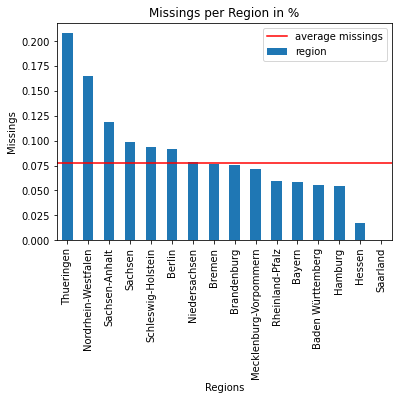

In [169]:
# get all the rows with missing information
missings = regions_table[(regions_table.wiki_area_sqkm == 'not found') | (regions_table.wiki_population == 'not found') | (regions_table.latitude == 'not found')]

# total percentage of missings
avg_nan = len(missings) / len(regions_table)

# total missings
print(f'There are {len(missings)} out of {len(regions_table)} (= {int(round(avg_nan, 2) * 100)}%) zipcode locations in total that are not evaluable due to missings in area, population or coordinates.')

# percentage of missings by region
(missings['region'].value_counts() / regions_table['region'].value_counts()).sort_values(ascending=False).plot.bar()
# specifying average missing in %
plt.axhline(y=avg_nan, color='r', linestyle='-', label='average missings')
plt.title('Missings per Region in %')
plt.ylabel('Missings')
plt.xlabel('Regions')
plt.legend()
plt.show()

#### The reasons for those missings are versatile. After inspecting some of them by hand (using the wiki_url) there are 4 main reasons:

- The details page has no table with area and population (e.g. "/wiki/Leinatal")
- The details page has a table but is built differently rgearding the HTML so it couldn't be parsed (e.g. "/wiki/Anrode")
- The coordinates couldn't be fetched despite population and area available on Wikipedia (e.g. "/wiki/Gefell")
- The search string for Wikipedia didn't bring the correct result on top so the wrong page was scraped (e.g. "/wiki/2._Tennis-Bundesliga_(Herren)" as a result of searching "Mannheim-Neckerau")

In [170]:
# also the data types are not perfect and we need to change them to investigate area and population data deeper (numerical)
regions_table.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   zipcode               7721 non-null   object
 1   city                  7721 non-null   object
 2   quarter               925 non-null    object
 3   district              6767 non-null   object
 4   region                7721 non-null   object
 5   search_string         7721 non-null   object
 6   wiki_title            7721 non-null   object
 7   wiki_url              7721 non-null   object
 8   wiki_area_sqkm        7721 non-null   object
 9   wiki_population       7721 non-null   object
 10  wiki_population_date  7721 non-null   object
 11  latitude              7721 non-null   object
 12  longitude             7721 non-null   object
 13  boundingbox           7721 non-null   object
dtypes: object(14)
memory usage: 7.3 MB


#### Transforming the columns to correct dtypes:

In [291]:
# Replacing the dots with commas and vice versa to be aligned with american standard
regions_table.wiki_population = regions_table.wiki_population.str.replace('\.', '', regex=True).replace(',', '.', regex=True)
regions_table.wiki_area_sqkm = regions_table.wiki_area_sqkm.str.replace('\.', '', regex=True).replace(',', '.', regex=True)

# transforming the data types
regions_table = regions_table.convert_dtypes()  # converts all columns to string
regions_table = regions_table.replace('not found', pd.NA, regex=False)  # converts the strings 'not found' to pd.NA
regions_table.wiki_population = pd.to_numeric(regions_table.wiki_population, downcast='unsigned', errors='coerce')  # transforming to smallest integer, else float.
regions_table.wiki_area_sqkm = pd.to_numeric(regions_table.wiki_area_sqkm, downcast='float', errors='coerce') # transforming to smallest float

# inspect results
regions_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               7721 non-null   string 
 1   city                  7721 non-null   string 
 2   quarter               925 non-null    string 
 3   district              6767 non-null   string 
 4   region                7721 non-null   string 
 5   search_string         7721 non-null   string 
 6   wiki_title            7706 non-null   string 
 7   wiki_url              7706 non-null   string 
 8   wiki_area_sqkm        7125 non-null   float32
 9   wiki_population       7123 non-null   float64
 10  wiki_population_date  7099 non-null   string 
 11  latitude              7684 non-null   string 
 12  longitude             7684 non-null   string 
 13  boundingbox           7684 non-null   string 
dtypes: float32(1), float64(1), string(12)
memory usage: 814.4 KB


#### Checking for Outliers
The best way to check for outliers is the area of the location in sqkm because we can assume that the zipcode size should be normally distributed around a population mean and the sizes of the regions should not differ too much (otherwise the area gets split into multiple zipcodes).
Therefore we use the Z-Scores and standard deviations (SD). A Z-Score simply put is the SD of a normal distribution and since we only check for areas bigger then ususal and we want to be 99% sure, we pick the one-sided Z-Score for that confidence from the normal distribution: 2.33.
So all plausible values fall within the mean + 2.33 * SD.

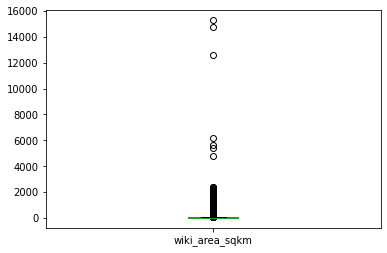

In [268]:
# the boxplot looks horrible. There are a lot of outliers..
regions_table.wiki_area_sqkm.plot.box()
plt.show()

In [279]:
# lets have a look at the top 10 highest area locations: seems like the district or region information was chosen, not the city or quarter information
regions_table.sort_values(by='wiki_area_sqkm', ascending=False).head(5)

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
5294,48143,Münster,Münster-Dom,<NA>,Nordrhein-Westfalen,48143 Münster-Dom,Bistum Münster,/wiki/Bistum_M%C3%BCnster,15265.000000,4305468.0,31. Dezember 2017[2],51.96311125,7.6258076555555565,"51.9627088, 51.9634982, 7.624984, 7.6265697"
4969,"33098, 33100, 33102, 33104, 33106, 33154, 33161",Paderborn,<NA>,Kreis Paderborn,Nordrhein-Westfalen,33098 Paderborn,Erzbistum Paderborn,/wiki/Erzbistum_Paderborn,14745.000000,4785898.0,31. Dezember 2016 AP 2017,51.71895955,8.764869778177559,"51.6793659, 51.7587989, 8.7104923, 8.8354886"
4847,"49074, 49076, 49078, 49080, 49082, 49084, 4908...",Osnabrück,<NA>,<NA>,Niedersachsen,49074 Osnabrück,Bistum Osnabrück,/wiki/Bistum_Osnabr%C3%BCck,12580.000000,2186946.0,31. Dezember 2018[2],52.2719595,8.047635,"52.2175488, 52.3374348, 7.9297121, 8.1806602"
5366,"50668, 50672, 50674, 50678, 50823, 50931, 5093...",Köln,<NA>,<NA>,Nordrhein-Westfalen,50668 Köln,Erzbistum Köln,/wiki/Erzbistum_K%C3%B6ln,6181.000000,5490036.0,31. Dezember 2018[2],50.938361,6.959974,"50.8304399, 51.0849743, 6.7725303, 7.162028"
4,68161,Mannheim,<NA>,<NA>,Baden Württemberg,68161 Mannheim,Metropolregion Rhein-Neckar,/wiki/Metropolregion_Rhein-Neckar,5637.779785,2403537.0,31. Dez. 2017,49.4892913,8.4673098,"49.4103619, 49.5904894, 8.4141602, 8.5899902"


In [281]:
# which value is the highest possible (99% confident with normal distribution)
max_99 = regions_table.wiki_area_sqkm.mean() + 2.33*(regions_table.wiki_area_sqkm.std())
print(f'The highest plausible value for an area is {round(max_99)} km².')
print(f'There are {len(regions_table[regions_table.wiki_area_sqkm > max_99])} entries that are bigger than this threshold.')

The highest plausible value for an area is 881 km².
There are 64 entries that are bigger than this threshold.


In [342]:
# dropping the entries with missings
clean_regions_table = regions_table.dropna(axis=0, how='any', subset=['wiki_area_sqkm', 'wiki_population', 'latitude'], inplace=True)

# dropping the entries with outliers
clean_regions_table = regions_table[regions_table.wiki_area_sqkm <= max_99]

# dropping the entries with the wiki_title ending in 'kreis' (those are not cities, but the parent category..)
clean_regions_table = clean_regions_table[~ clean_regions_table.wiki_title.str.endswith('kreis')]

# clean out search strings with less than 4 characters (they make no sense (Bad Staffelstein was cut to Bad e.g.))
clean_regions_table = clean_regions_table[clean_regions_table.search_string.map(lambda x: len(str(x)) > 3)]
clean_regions_table

# saving the clean table
clean_regions_table.reset_index(drop=True, inplace=True)
clean_regions_table.to_feather('.\\Clean_Neighborhoods_Germany.feather')

#### Visualizing the newly cleaned table

In [236]:
print(f'The new table consists of {len(clean_regions_table)} entries compared to the old table with {len(regions_table)} entries.')
print(f'{round((1-len(clean_regions_table) / len(regions_table)) *100)}% of the entries were dropped to to data cleansing.')

The new table consists of 7030 entries compared to the old table with 7721 entries.
9% of the entries were dropped to to data cleansing.


In [237]:
# the new descriptive summary is:
clean_regions_table.describe()

,wiki_area_sqkm,wiki_population
count,7030.000000,7.030000e+03
mean,41.712402,1.257730e+04
std,67.120201,4.166076e+04
min,0.201000,1.000000e+01
25%,11.177500,1.590000e+03
50%,24.145000,4.035500e+03
75%,49.339999,1.051300e+04
max,870.719971,1.488202e+06


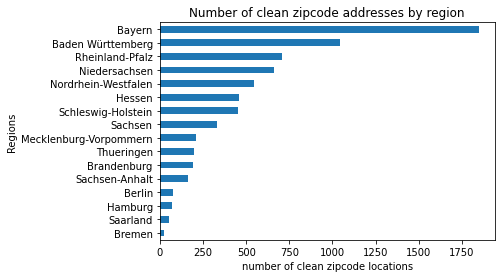

In [238]:
# number of entries
clean_regions_table.region.value_counts(ascending=True).plot.barh()
plt.title('Number of clean zipcode addresses by region')
plt.ylabel('Regions')
plt.xlabel('number of clean zipcode locations')
plt.show()

## Foursquare API: Adding Retail Store Information
As a last step for the data collection the Foursquare Developer API is used to map Fashion Retail Shops with their distance to the location data. The Foursquare API therefore uses the Latitudes and Longitudes of the zipcode locations from the previous steps and returns all the stores names, categories, latitudes and longitudes in a user-defined circumference (here: 10km). This Data will then be used to geocode the retail density for the zipcode locations.

In [56]:
# load the clean_regions_table
clean_regions_table = pd.read_feather('.\\Clean_Neighborhoods_Germany.feather')
clean_regions_table.head(2)

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,31. Dez. 2020,49.6375005,9.3110464,"49.6374505, 49.6375505, 9.3109964, 9.3110964"
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,31. Dez. 2020,49.56522905,9.07583865434271,"49.40522905, 49.72522905, 8.9158386543427, 9.2..."


### 7.1 Collecting the API Information

#### loading the passwords for the Foursquare API from a safe environment

In [57]:

try:  # error handling
    with open('.\API_Keys.json', 'r') as handle:
        pw = json.load(handle)

    CLIENT_ID = pw['Foursquare']['CLIENT_ID']
    CLIENT_SECRET = pw['Foursquare']['CLIENT_SECRET']

except:  # print error message
    print(f'Oops...there was an "{sys.exc_info()[0].__name__}" ! Please check the pw-file manually.')

else:
    print('The Loading of the Passwords was succesful!')

The Loading of the Passwords was succesful!


#### Getting the relevant venue categories
We are only interested in the categories for clothing venues (fashion retail). We find the information on: https://developer.foursquare.com/docs/build-with-foursquare/categories/ 

In [58]:
# possible category IDs
clothing_stores = '4bf58dd8d48988d103951735'

# outlet_mall = '5744ccdfe4b0c0459246b4df'
# outlet_store = '52f2ab2ebcbc57f1066b8b35'
# shopping_mall = '4bf58dd8d48988d1fd941735'
# shopping_plaza = '5744ccdfe4b0c0459246b4dc'

# version & limit was already initialized above
category_id = clothing_stores

#### make the API Calls and save the results

In [86]:
# Foursquare API version
VERSION = '20180605'

# A default Foursquare API limit value
LIMIT = 100

# set a request-header to not get timed out (504) for crawling
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1)'}

# prepare lists for looping
wiki_url_list = clean_regions_table.wiki_url.to_list()
lat_list = clean_regions_table.latitude.to_list()
lon_list = clean_regions_table.longitude.to_list()
area_list = clean_regions_table.wiki_area_sqkm.to_list()
index_list = clean_regions_table.index.to_list()
venues_list=[]

# loop through the zipcode locations
for wiki_url, lat, lon, area, index in zip(wiki_url_list, lat_list, lon_list, area_list, index_list):

    #compute the radius for the location
    radius = round(np.sqrt(area / np.pi) * 1000)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon,
        category_id, 
        radius, 
        LIMIT)

    # since the Foursquare API only allows for 5000 userless API Calls per hour per venues-category we have to set a sleep timer to not exceed the limit
    # 60*60 = 3600 seconds per hour with 5000 possible API calls = 3600/5000 = 0.72 seconds
    sleep(1)

    # make the GET request
    response = requests.get(url, headers=headers)

    try:
        # extract relevant part of json response
        results = response.json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            index,
            wiki_url,
            v['venue']['name'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['shortName'],
            radius,
            v['venue']['location']['distance'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    # error handling
    except:
        print('AN ERROR OCCURRED!')
        print(f'System Error: {sys.exc_info()[0].__name__} or HTTP Error (status code): {response.status_code} at index / url: {index, wiki_url}.')
        break

    # watch the progress while everything goes to plan (hopefully)
    else:
        rate_limit = response.headers["X-RateLimit-Remaining"]
        print(f'Rate-Limit is at: {rate_limit} and zipcode_index is at: {index}')
        ts = int(response.headers['X-RateLimit-Reset'])
        print('Rate Limit will be reset at:', datetime.utcfromtimestamp(ts) + timedelta(hours=2))

2:20:21
Rate-Limit is at: 4020 and zipcode_index is at: 6836
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4019 and zipcode_index is at: 6837
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4018 and zipcode_index is at: 6838
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4017 and zipcode_index is at: 6839
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4016 and zipcode_index is at: 6840
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4015 and zipcode_index is at: 6841
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4014 and zipcode_index is at: 6842
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4013 and zipcode_index is at: 6843
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4012 and zipcode_index is at: 6844
Rate Limit will be reset at: 2021-07-22 12:20:21
Rate-Limit is at: 4011 and zipcode_index is at: 6845
Rate Limit will be re

#### API results to DataFrame:

In [94]:
# iterate through tuple list
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

#change column names
nearby_venues.columns = ['zipcode_index',
                         'wiki_url',
                         'venue_name',
                         'venue_category',
                         'venue_subcategory',
                         'search_radius',
                         'venue_distance',
                         'venue_latitude',
                         'venue_longitude']
#show result
nearby_venues

,zipcode_index,wiki_url,venue_name,venue_category,venue_subcategory,search_radius,venue_distance,venue_latitude,venue_longitude
0,0,/wiki/Walld%C3%BCrn,KUHN Maßkonfektion - Schneeberg,Clothing Store,Apparel,5805,4696,49.637920,9.245910
1,2,/wiki/Innenstadt/Jungbusch,Zara,Clothing Store,Apparel,1203,975,49.486893,8.445949
2,2,/wiki/Innenstadt/Jungbusch,Hollister Co.,Clothing Store,Apparel,1203,1054,49.485769,8.447503
3,2,/wiki/Innenstadt/Jungbusch,H&M,Clothing Store,Apparel,1203,1102,49.485317,8.447513
4,2,/wiki/Innenstadt/Jungbusch,Lemis Modehaus,Clothing Store,Apparel,1203,441,49.492000,8.455678
...,...,...,...,...,...,...,...,...,...
18418,7025,/wiki/M%C3%BChlhausen/Th%C3%BCringen,DEICHMANN,Shoe Store,Shoes,6450,980,51.202551,10.467690
18419,7025,/wiki/M%C3%BChlhausen/Th%C3%BCringen,Fielmann – Ihr Optiker,Optical Shop,Optical,6450,109,51.209913,10.457535
18420,7025,/wiki/M%C3%BChlhausen/Th%C3%BCringen,Deichmann,Shoe Store,Shoes,6450,4753,51.252030,10.454261
18421,7025,/wiki/M%C3%BChlhausen/Th%C3%BCringen,Annette Kahle Lust auf Mode,Accessories Store,Accessories,6450,4888,51.165745,10.451655


#### Saving the results to disc

In [96]:
nearby_venues.to_feather('.\\nearby_venues.feather')
print('Venues DataFrame was saved to disc!')

Venues DataFrame was saved to disc!


### 7.2 Data Cleaning
The first step is again to check the data for quality or missings.
Second step:
One location can have multiple venues. Because we are interested in the number of venues and the average distance of those venues, we have to aggregate the data to the location level and save it as separate columns.

#### Check for NA:

In [102]:
# are there any missings?
print(f'Missings in columns for the venues table: \n\n{nearby_venues.isna().sum()}')

Misssings for the venues table: 

zipcode_index        0
wiki_url             0
venue_name           0
venue_category       0
venue_subcategory    0
search_radius        0
venue_distance       0
venue_latitude       0
venue_longitude      0
dtype: int64


#### Check for duplicates:

In [106]:
print(f'There are {nearby_venues.duplicated(keep=False).sum()} duplicates in the DataFrame (including the original).')
nearby_venues[nearby_venues.duplicated(keep=False)]

There are 38 duplicates in the DataFrame (including the original).


,zipcode_index,wiki_url,venue_name,venue_category,venue_subcategory,search_radius,venue_distance,venue_latitude,venue_longitude
1621,768,/wiki/Stegen,TANDEM TRANSIT,Clothing Store,Apparel,2894,2365,48.000000,8.000000
1622,768,/wiki/Stegen,TANDEM TRANSIT,Clothing Store,Apparel,2894,2365,48.000000,8.000000
2647,1107,/wiki/Feldmoching-Hasenbergl,H&M,Clothing Store,Apparel,3035,2331,48.183785,11.532424
2649,1107,/wiki/Feldmoching-Hasenbergl,H&M,Clothing Store,Apparel,3035,2331,48.183785,11.532424
2678,1110,/wiki/Moosach_(M%C3%BCnchen),H&M,Clothing Store,Apparel,1879,1678,48.183785,11.532424
2684,1110,/wiki/Moosach_(M%C3%BCnchen),H&M,Clothing Store,Apparel,1879,1678,48.183785,11.532424
6594,2912,/wiki/Berlin-Alt-Treptow,Mona Lisa & Leonardo Inhaber,Clothing Store,Apparel,857,268,52.490493,13.457831
6595,2912,/wiki/Berlin-Alt-Treptow,Mona Lisa & Leonardo Inhaber,Clothing Store,Apparel,857,268,52.490493,13.457831
7145,3046,/wiki/Bad_Belzig,La Maria Moda,Women's Store,Women's Store,8669,109,52.141110,12.587910
7146,3046,/wiki/Bad_Belzig,La Maria Moda,Women's Store,Women's Store,8669,109,52.141110,12.587910


In [107]:
# drop the duplicates (20 entries are dropped)
nearby_venues = nearby_venues.drop_duplicates(keep='first', ignore_index=True)

In [112]:
# get all distinct categories: seems like there are some non-fashion categories in there
set(nearby_venues.venue_category)

{'Accessories Store',
 'Adult Boutique',
 'Advertising Agency',
 'Arts & Crafts Store',
 'Automotive Shop',
 'Baby Store',
 'Bike Shop',
 'Board Shop',
 'Boutique',
 'Bridal Shop',
 'Business Service',
 'Café',
 'Clothing Store',
 'Construction & Landscaping',
 'Cosmetics Shop',
 'Department Store',
 'Design Studio',
 "Doctor's Office",
 'Electronics Store',
 'Fabric Shop',
 'Factory',
 'Farm',
 'Farmers Market',
 'Flea Market',
 'Flower Shop',
 'Furniture / Home Store',
 'Garden Center',
 'General Entertainment',
 'Gift Shop',
 'Grocery Store',
 'Hardware Store',
 'Health & Beauty Service',
 'Hobby Shop',
 'Home Service',
 'Hunting Supply',
 'Italian Restaurant',
 'Jewelry Store',
 'Kids Store',
 'Leather Goods Store',
 'Lingerie Store',
 'Locksmith',
 'Luggage Store',
 'Medical Center',
 'Medical Supply Store',
 "Men's Store",
 'Miscellaneous Shop',
 'Music Store',
 'Nail Salon',
 'Office',
 'Optical Shop',
 'Other Repair Shop',
 'Outdoor Supply Store',
 'Outlet Store',
 'Paper / Off

In [130]:
# list with correct categories from https://developer.foursquare.com/docs/build-with-foursquare/categories/ under "Clothing Store" + inspected categories
# + 'Outlet Store', 'Miscellaneous Shop', 'Leather Goods Store', 'Jewelry Store', 'Factory', 'Bridal Shop', 'Adult Boutique', 'Arts & Crafts Store'
cat_clean = ['Outlet Store',
             'Miscellaneous Shop',
             'Leather Goods Store',
             'Jewelry Store', 'Factory',
             'Bridal Shop', 'Adult Boutique',
             'Arts & Crafts Store',
             'Clothing Store',
             'Accessories Store',
             'Boutique',
             'Kids Store',
             'Lingerie Store',
             "Men's Store",
             'Shoe Store',
             "Women's Store"]

#### Cleaning the wrong categories and plotting the remaining ones
As we can see the main categories from Foursquare are the absolute dominant ones --> we can proceed

<AxesSubplot:>

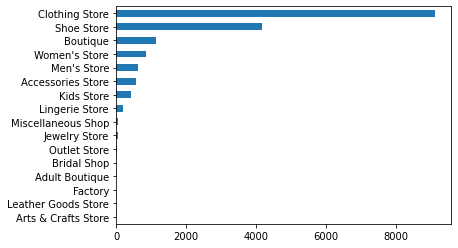

In [140]:
# cleaning
nearby_venues = nearby_venues[nearby_venues.venue_category.isin(cat_clean)]

# plotting the categories
nearby_venues.venue_category.value_counts(ascending=True).plot.barh()
plt.show()

#### But there are still a lot of wrong venues within the API categories. E.g. venues with 'gerät' (machine) or 'technik' (technic) in their name

In [153]:
# drop all venues with 'gerät' in their name
nearby_venues = nearby_venues[~ nearby_venues.venue_name.str.contains('gerät', case=False, regex=True)]

# drop all venues with 'technik' in their name
nearby_venues = nearby_venues[~ nearby_venues.venue_name.str.contains('technik', case=False, regex=True)]

# drop all venues with 'raiffeisen' in their name
nearby_venues = nearby_venues[~ nearby_venues.venue_name.str.contains('raiffeisen', case=False, regex=True)]

# drop all venues with 'maschine' in their name
nearby_venues = nearby_venues[~ nearby_venues.venue_name.str.contains('maschine', case=False, regex=True)]

#### Last check is search_radius and venue_distance
Search radius is dependent on the total area. The largest area was nearly 900sqkm wide, which equals a radius of approximately 17km.
Minimum distance could be 0 because if the shop is in the middle of the region they got the same coordinates and maximum distance should be close to the maximum radius.

In [157]:
# radius and distance look fine
nearby_venues[['search_radius', 'venue_distance']].describe()

,search_radius,venue_distance
count,17070.000000,17070.000000
mean,4671.471002,2132.501113
std,3293.248465,2381.636877
min,253.000000,0.000000
25%,2228.000000,540.000000
50%,4056.000000,1317.000000
75%,5956.000000,2924.000000
max,16648.000000,16281.000000


#### Result of the Foursuare cleaning:
Before the cleaning we had 18423 rows, after the cleaning we have 17070 rows left. That equals a loss of ~7%!

In [167]:
# saving the results to disc
nearby_venues.reset_index(drop=True, inplace=True)
nearby_venues.to_feather('.\\nearby_venues_clean.feather')

#### Which category appears the most after cleaning and which shop has the most appearances in germany?

In [168]:
# opening the file
nearby_venues_clean = pd.read_feather('.\\nearby_venues_clean.feather')

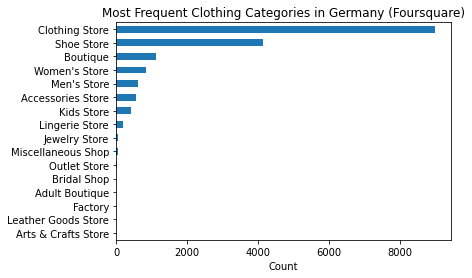

In [174]:
# plotting the categories
nearby_venues_clean.venue_category.value_counts(ascending=True).plot.barh()
plt.title('Most Frequent Clothing Categories in Germany (Foursquare)')
plt.xlabel('Count')
plt.show()

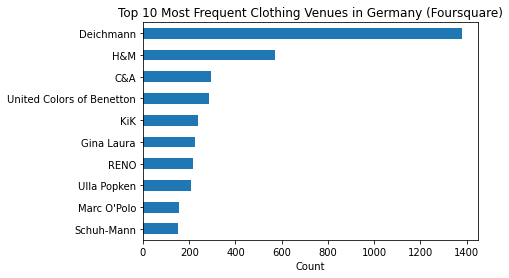

In [173]:
# plotting the top 10 venue names
nearby_venues_clean.venue_name.value_counts().head(10).sort_values().plot.barh()
plt.title('Top 10 Most Frequent Clothing Venues in Germany (Foursquare)')
plt.xlabel('Count')
plt.show()

## 8. Benchmarking the Neighborhoods
In the final step we join the two tables (Foursquare & Zip/Wiki/Geo) to compute our variables of interest (population density, retail density and potential).
We then give a ranking of the most potent regions for E-Commerce and visualize the results. 

In [239]:
# opening the Zip/Wiki/Geo File
clean_regions_table = pd.read_feather('.\\Clean_Neighborhoods_Germany.feather')
print(f'The shape of the table "clean_regions_table" is: {clean_regions_table.shape}.')

# opening the Foursquare Venues File
nearby_venues_clean = pd.read_feather('.\\nearby_venues_clean.feather')
print(f'The shape of the table "nearby_venues_clean" is: {nearby_venues_clean.shape}.')

The shape of the table "clean_regions_table" is: (7030, 14).
The shape of the table "nearby_venues_clean" is: (17070, 9).


### 8.1 Joining the Data
A location can have multiple venues and some locations have none. Those with none count as zero and we want to keep them, that's why a left join is suitable.

In [240]:
# join the tables (left join because we want to keep the regions)
neighborhood_venues = pd.merge(clean_regions_table, nearby_venues_clean, how='left', on='wiki_url')
neighborhood_venues = neighborhood_venues.drop('zipcode_index', axis=1)
print(f'Shape of joined table is: {neighborhood_venues.shape}')
neighborhood_venues.head(5)

Shape of joined table is: (25208, 21)


,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,...,latitude,longitude,boundingbox,venue_name,venue_category,venue_subcategory,search_radius,venue_distance,venue_latitude,venue_longitude
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,...,49.6375005,9.3110464,"49.6374505, 49.6375505, 9.3109964, 9.3110964",KUHN Maßkonfektion - Schneeberg,Clothing Store,Apparel,5805.0,4696.0,49.637920,9.245910
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,...,49.56522905,9.07583865434271,"49.40522905, 49.72522905, 8.9158386543427, 9.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,...,49.4948819,8.4514877,"49.4848819, 49.5048819, 8.4414877, 8.4614877",Zara,Clothing Store,Apparel,1203.0,975.0,49.486893,8.445949
3,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,...,49.4948819,8.4514877,"49.4848819, 49.5048819, 8.4414877, 8.4614877",Hollister Co.,Clothing Store,Apparel,1203.0,1054.0,49.485769,8.447503
4,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,...,49.4948819,8.4514877,"49.4848819, 49.5048819, 8.4414877, 8.4614877",H&M,Clothing Store,Apparel,1203.0,1102.0,49.485317,8.447513


There are more Rows now than the left and the right table combined, which means that our left table (clean regions) had duplicate wiki_url.
That's possible because sometimes Wikipedia groups neighborhoods together. The data is not perfect, but plausible and can be seen as a proxy. Here's an example:

In [241]:
# see how duplicate wiki_url are plausible
clean_regions_table[clean_regions_table.wiki_url == '/wiki/Neuhausen-Nymphenburg']

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,wiki_population_date,latitude,longitude,boundingbox
1099,80637,München,München-Neuhausen,<NA>,Bayern,80637 München-Neuhausen,Neuhausen-Nymphenburg,/wiki/Neuhausen-Nymphenburg,12.91,100233.0,31. Mai 2020,48.162230097213666,11.536139498078791,"48.002230097214, 48.322230097214, 11.376139498..."
1100,80638,München,München-Nymphenburg,<NA>,Bayern,80638 München-Nymphenburg,Neuhausen-Nymphenburg,/wiki/Neuhausen-Nymphenburg,12.91,100233.0,31. Mai 2020,48.1465005,11.4909752,"48.1464505, 48.1465505, 11.4909252, 11.4910252"


In [242]:
# save the table to disc
# saving the results to disc
neighborhood_venues.reset_index(drop=True, inplace=True)
neighborhood_venues.to_feather('.\\neighborhood_venues.feather')

### 8.2 Feature Engineering
There are three features that need to be computed from the existing data:

- population density: population / neighborhood area

- retail density: shop count / neighborhood area
    
- potential: 1/2 * (normalized(population density) + (normalized(retail density)))


Potential is the final variable that's evaluated for every neighborhood. It is normalized (0-1 range) so every neighborhood has a percentile rank.

In [93]:
# load the table
neighborhood_venues = pd.read_feather('.\\neighborhood_venues.feather')

In [244]:
# first select only the needed columns for population density
neighborhoods_ratings = clean_regions_table.drop(['wiki_population_date', 'boundingbox'], axis=1)
neighborhoods_ratings.head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,49.6375005,9.3110464
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,49.56522905,9.07583865434271
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,49.4948819,8.4514877
3,68163,Mannheim,Mannheim-Neuostheim,<NA>,Baden Württemberg,68163 Mannheim-Neuostheim,Neuostheim/Neuhermsheim,/wiki/Neuostheim/Neuhermsheim,5.240000,7387.0,49.4788199,8.5049695
4,68165,Mannheim,Mannheim-Schwetzingerstadt,<NA>,Baden Württemberg,68165 Mannheim-Schwetzingerstadt,Schwetzingerstadt/Oststadt,/wiki/Schwetzingerstadt/Oststadt,4.410000,22385.0,49.480345391387736,8.482308669466056


In [292]:
# correct Hamburg-Sternschanze
neighborhoods_ratings.at[neighborhoods_ratings.quarter == 'Hamburg-Sternschanze', 'wiki_title'] = 'Hamburg-Sternschanze'
neighborhoods_ratings.at[neighborhoods_ratings.quarter == 'Hamburg-Sternschanze', 'wiki_url'] = '/wiki/Hamburg-Sternschanze'
neighborhoods_ratings.at[neighborhoods_ratings.quarter == 'Hamburg-Sternschanze', 'wiki_area_sqkm'] = 0.6
neighborhoods_ratings.at[neighborhoods_ratings.quarter == 'Hamburg-Sternschanze', 'wiki_population'] = 8092

#### First compute and normalize the population density

In [294]:
# then compute the population density
neighborhoods_ratings['population_per_sqkm'] = neighborhoods_ratings.wiki_population / neighborhoods_ratings.wiki_area_sqkm

# then normalize
neighborhoods_ratings['population_per_sqkm_norm'] = MinMaxScaler().fit_transform(neighborhoods_ratings.population_per_sqkm.values.reshape(-1, 1)) 

# inspect the most populated areas
neighborhoods_ratings.sort_values(by='population_per_sqkm_norm', ascending=False).head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude,population_per_sqkm,population_per_sqkm_norm
3189,20253,Hamburg,Hamburg-Hoheluft-West,<NA>,Hamburg,20253 Hamburg-Hoheluft-West,Hamburg-Hoheluft-West,/wiki/Hamburg-Hoheluft-West,0.700,13435.0,53.5807542,9.9683313,19192.857470,1.000000
3190,20259,Hamburg,Hamburg-Eimsbüttel,<NA>,Hamburg,20259 Hamburg-Eimsbüttel,Hamburg-Eimsbüttel,/wiki/Hamburg-Eimsb%C3%BCttel,3.200,58004.0,53.606281949999996,9.922981787526826,18126.249730,0.944422
53,70182,Stuttgart,Stuttgart-Heusteigviertel,<NA>,Baden Württemberg,70182 Stuttgart-Heusteigviertel,Heusteigviertel,/wiki/Heusteigviertel,0.216,3889.0,48.771113799999995,9.180585574142242,18004.629163,0.938085
2894,10369,Berlin,Berlin-Fennpfuhl,<NA>,Berlin,10369 Berlin-Fennpfuhl,Berlin-Fennpfuhl,/wiki/Berlin-Fennpfuhl,2.120,33751.0,52.5287849,13.4734687,15920.283878,0.829476
2942,13357,Berlin,Berlin-Gesundbrunnen,<NA>,Berlin,13357 Berlin-Gesundbrunnen,Berlin-Gesundbrunnen,/wiki/Berlin-Gesundbrunnen,6.130,93862.0,52.5486453,13.3902169,15311.908360,0.797775


#### Second compute and normalize the retail / venue density

In [296]:
# compute the retail count
venue_name_count = neighborhood_venues[['search_string', 'venue_name']].groupby(by=['search_string']).count()
venue_name_count.rename({'venue_name': 'venue_count'}, axis=1, inplace=True)
venue_name_count.sort_values(by='venue_count', ascending=False)

,venue_count
search_string,
40629 Düsseldorf-Ludenberg,250
40213 Düsseldorf-Carlstadt,250
40210 Düsseldorf-Stadtmitte,250
22767 Hamburg-Altona-Altstadt,245
22763 Hamburg-Ottensen,245
...,...
55296 Gau-Bischofsheim,0
55291 Saulheim,0
55288 Schornsheim,0


In [297]:
# join the tables
neighborhoods_potential = pd.merge(neighborhoods_ratings, venue_name_count, how='left', on='search_string')
neighborhoods_potential.head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude,population_per_sqkm,population_per_sqkm_norm,venue_count
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,49.6375005,9.3110464,109.567438,0.005624,1
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,49.56522905,9.07583865434271,175.766913,0.009074,0
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,49.4948819,8.4514877,6876.043668,0.358206,14
3,68163,Mannheim,Mannheim-Neuostheim,<NA>,Baden Württemberg,68163 Mannheim-Neuostheim,Neuostheim/Neuhermsheim,/wiki/Neuostheim/Neuhermsheim,5.240000,7387.0,49.4788199,8.5049695,1409.732886,0.073372,1
4,68165,Mannheim,Mannheim-Schwetzingerstadt,<NA>,Baden Württemberg,68165 Mannheim-Schwetzingerstadt,Schwetzingerstadt/Oststadt,/wiki/Schwetzingerstadt/Oststadt,4.410000,22385.0,49.480345391387736,8.482308669466056,5075.963894,0.264409,27


In [298]:
# compute the retail density
neighborhoods_potential['retail_density_per_sqkm'] = neighborhoods_potential.venue_count / neighborhoods_potential.wiki_area_sqkm
neighborhoods_potential.head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude,population_per_sqkm,population_per_sqkm_norm,venue_count,retail_density_per_sqkm
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,49.6375005,9.3110464,109.567438,0.005624,1,0.009445
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,49.56522905,9.07583865434271,175.766913,0.009074,0,0.000000
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,49.4948819,8.4514877,6876.043668,0.358206,14,3.076923
3,68163,Mannheim,Mannheim-Neuostheim,<NA>,Baden Württemberg,68163 Mannheim-Neuostheim,Neuostheim/Neuhermsheim,/wiki/Neuostheim/Neuhermsheim,5.240000,7387.0,49.4788199,8.5049695,1409.732886,0.073372,1,0.190840
4,68165,Mannheim,Mannheim-Schwetzingerstadt,<NA>,Baden Württemberg,68165 Mannheim-Schwetzingerstadt,Schwetzingerstadt/Oststadt,/wiki/Schwetzingerstadt/Oststadt,4.410000,22385.0,49.480345391387736,8.482308669466056,5075.963894,0.264409,27,6.122449


In [299]:
# normalize the retail density
neighborhoods_potential['retail_density_per_sqkm_norm'] = MinMaxScaler().fit_transform(neighborhoods_potential.retail_density_per_sqkm.values.reshape(-1, 1))
neighborhoods_potential.head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude,population_per_sqkm,population_per_sqkm_norm,venue_count,retail_density_per_sqkm,retail_density_per_sqkm_norm
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,49.6375005,9.3110464,109.567438,0.005624,1,0.009445,0.000133
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,49.56522905,9.07583865434271,175.766913,0.009074,0,0.000000,0.000000
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,49.4948819,8.4514877,6876.043668,0.358206,14,3.076923,0.043439
3,68163,Mannheim,Mannheim-Neuostheim,<NA>,Baden Württemberg,68163 Mannheim-Neuostheim,Neuostheim/Neuhermsheim,/wiki/Neuostheim/Neuhermsheim,5.240000,7387.0,49.4788199,8.5049695,1409.732886,0.073372,1,0.190840,0.002694
4,68165,Mannheim,Mannheim-Schwetzingerstadt,<NA>,Baden Württemberg,68165 Mannheim-Schwetzingerstadt,Schwetzingerstadt/Oststadt,/wiki/Schwetzingerstadt/Oststadt,4.410000,22385.0,49.480345391387736,8.482308669466056,5075.963894,0.264409,27,6.122449,0.086435


In [301]:
# finally compute the potential
# and don't forget to invers the retail density: For E-Commerce it is High-Potential when there is LOW retail density!
neighborhoods_potential['potential'] = (1 - neighborhoods_potential.retail_density_per_sqkm_norm) + neighborhoods_potential.population_per_sqkm_norm
neighborhoods_potential['potential_norm'] = MinMaxScaler().fit_transform(neighborhoods_potential.potential.values.reshape(-1, 1))
neighborhoods_potential.head()

,zipcode,city,quarter,district,region,search_string,wiki_title,wiki_url,wiki_area_sqkm,wiki_population,latitude,longitude,population_per_sqkm,population_per_sqkm_norm,venue_count,retail_density_per_sqkm,retail_density_per_sqkm_norm,potential,potential_norm
0,"63928, 74731",Walldürn,<NA>,Neckar-Odenwald-Kreis,Baden Württemberg,63928 Walldürn,Walldürn,/wiki/Walld%C3%BCrn,105.879997,11601.0,49.6375005,9.3110464,109.567438,0.005624,1,0.009445,0.000133,1.005491,0.514287
1,"64754, 69412, 69429, 69434",Eberbach,<NA>,Rhein-Neckar-Kreis,Baden Württemberg,64754 Eberbach,Eberbach,/wiki/Eberbach,81.169998,14267.0,49.56522905,9.07583865434271,175.766913,0.009074,0,0.000000,0.000000,1.009074,0.516326
2,68159,Mannheim,Mannheim-Mühlau,<NA>,Baden Württemberg,68159 Mannheim-Mühlau,Innenstadt/Jungbusch,/wiki/Innenstadt/Jungbusch,4.550000,31286.0,49.4948819,8.4514877,6876.043668,0.358206,14,3.076923,0.043439,1.314767,0.690326
3,68163,Mannheim,Mannheim-Neuostheim,<NA>,Baden Württemberg,68163 Mannheim-Neuostheim,Neuostheim/Neuhermsheim,/wiki/Neuostheim/Neuhermsheim,5.240000,7387.0,49.4788199,8.5049695,1409.732886,0.073372,1,0.190840,0.002694,1.070678,0.551391
4,68165,Mannheim,Mannheim-Schwetzingerstadt,<NA>,Baden Württemberg,68165 Mannheim-Schwetzingerstadt,Schwetzingerstadt/Oststadt,/wiki/Schwetzingerstadt/Oststadt,4.410000,22385.0,49.480345391387736,8.482308669466056,5075.963894,0.264409,27,6.122449,0.086435,1.177974,0.612464


#### saving the results to disc

In [12]:
# saving as feather
neighborhoods_potential.to_feather('.\\German_Neighborhoods_Potential.feather')
neighborhoods_potential.to_csv('.\\German_Neighborhoods_Potential.csv')

### 8.3 Visualizing the high potential regions

In [80]:
# load the table
neighborhoods_potential = pd.read_feather('.\\German_Neighborhoods_Potential.feather')

In [15]:
# build the top 10 table

# choose columns
column_list = ['zipcode', 'city', 'quarter', 'region', 'wiki_url', 'population_per_sqkm_norm', 'retail_density_per_sqkm_norm', 'potential_norm']

# build the table
top_neighborhoods = neighborhoods_potential[column_list].sort_values(by='potential_norm', ascending=False)

#rename the columns
top_neighborhoods.rename({'population_per_sqkm_norm': 'population_density',
                          'retail_density_per_sqkm_norm': 'retail_sparsity',
                          'potential_norm': 'potential',
                          'wiki_url': 'learn_more'}, axis=1, inplace=True)

# invers the retail density to sparsity
top_neighborhoods['retail_sparsity'] = top_neighborhoods.retail_sparsity.map(lambda x: 1-x)

In [16]:
# saving to disc
top_neighborhoods.reset_index(drop=True, inplace=True)
top_neighborhoods.to_feather('.\\Top_ECommerce_Neighborhoods.feather')
top_neighborhoods.to_csv('.\\Top_ECommerce_Neighborhoods.csv')

#### top 20 Neigborhoods

In [3]:
# loading the data
top_neighborhoods = pd.read_feather('.\\Top_ECommerce_Neighborhoods.feather')

In [3]:
# viewing the top 20 neighborhoods
top_neighborhoods.head(20).style.format({'population_density': '{:,.2f}',
                                         'retail_sparsity': '{:,.2f}',
                                         'potential': '{:,.2f}'}) \
                                .background_gradient(subset='population_density', cmap='Reds') \
                                .background_gradient(subset='retail_sparsity', cmap='Reds') \
                                .bar(subset='potential', color='darkred')

,zipcode,city,quarter,region,learn_more,population_density,retail_sparsity,potential
0,20253,Hamburg,Hamburg-Hoheluft-West,Hamburg,/wiki/Hamburg-Hoheluft-West,1.00,0.86,1.00
1,10369,Berlin,Berlin-Fennpfuhl,Berlin,/wiki/Berlin-Fennpfuhl,0.83,0.99,0.98
2,70182,Stuttgart,Stuttgart-Heusteigviertel,Baden Württemberg,/wiki/Heusteigviertel,0.94,0.87,0.97
3,13357,Berlin,Berlin-Gesundbrunnen,Berlin,/wiki/Berlin-Gesundbrunnen,0.80,0.97,0.95
4,20259,Hamburg,Hamburg-Eimsbüttel,Hamburg,/wiki/Hamburg-Eimsb%C3%BCttel,0.94,0.83,0.95
5,22049,Hamburg,Hamburg-Dulsberg,Hamburg,/wiki/Hamburg-Dulsberg,0.75,0.99,0.93
6,12043,Berlin,Berlin-Neukölln,Berlin,/wiki/Berlin-Neuk%C3%B6lln,0.73,0.99,0.93
7,12353,Berlin,Berlin-Gropiusstadt,Berlin,/wiki/Berlin-Gropiusstadt,0.74,0.98,0.92
8,10969,Berlin,Berlin-Kreuzberg,Berlin,/wiki/Berlin-Kreuzberg,0.77,0.95,0.92
9,81675,München,München-Haidhausen,Bayern,/wiki/Au-Haidhausen,0.76,0.94,0.91


#### Distribution of the 3 KPIs: Population Density, Retail Sparsity and Potential

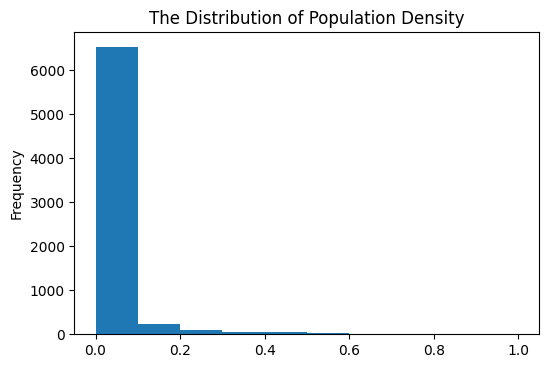

In [75]:
# the population density
top_neighborhoods.population_density.plot.hist()
plt.title('The Distribution of Population Density')
plt.show()

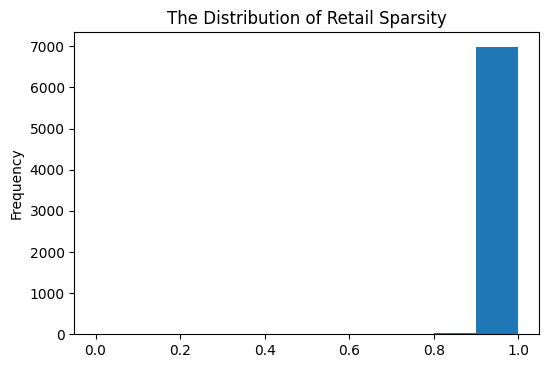

In [70]:
# the retail sparsity
top_neighborhoods.retail_sparsity.plot.hist()
plt.title('The Distribution of Retail Sparsity')
plt.show()

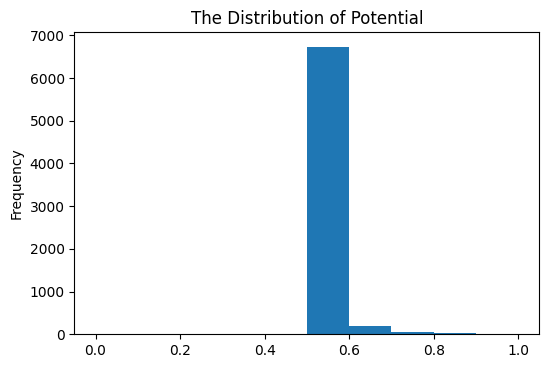

In [74]:
# the potential
top_neighborhoods.potential.plot.hist()
plt.title('The Distribution of Potential')
plt.show()

#### Ranking Regions by average potential

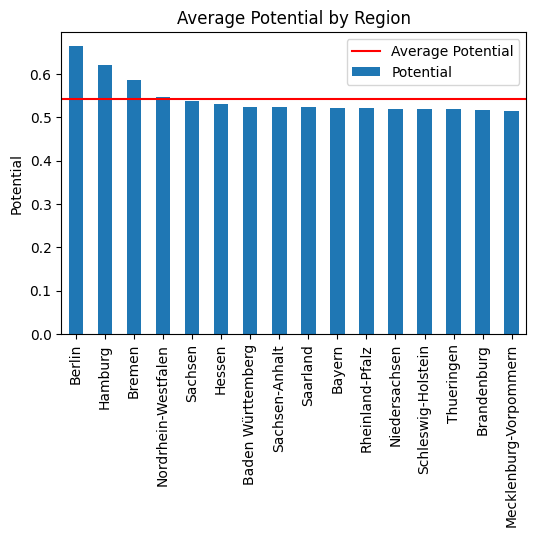

In [33]:
#change size of graphs
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

# compute average (red line)
avg_pot = top_neighborhoods[['region', 'potential']].groupby(by='region').agg('mean').values.mean()

# plot graph
top_neighborhoods[['region', 'potential']].groupby(by='region').agg('mean').sort_values(by='potential', ascending=False).plot.bar()
plt.title('Average Potential by Region')
plt.axhline(y=avg_pot, color='r', linestyle='-', label='Average Potential')
plt.legend().get_texts()[1].set_text('Potential')
plt.xlabel('')
plt.ylabel('Potential')
plt.show()

#### Ranking Regions by most high potential (>=0.7) locations

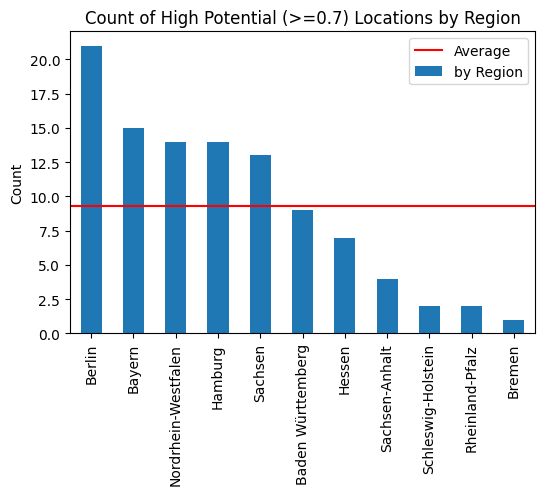

In [42]:
# computing the average
avg_count = top_neighborhoods.loc[top_neighborhoods.potential >= 0.7, 'region'].value_counts(ascending=True).values.mean()

# plotting the graph
top_neighborhoods.loc[top_neighborhoods.potential >= 0.7, 'region'].value_counts(ascending=False).plot.bar()
plt.title('Count of High Potential (>=0.7) Locations by Region')
plt.ylabel('Count')
plt.axhline(y=avg_count, color='r', linestyle='-', label='Average')
plt.legend().get_texts()[1].set_text('by Region')
plt.show()

#### Ranking Top 10 Cities by average potential

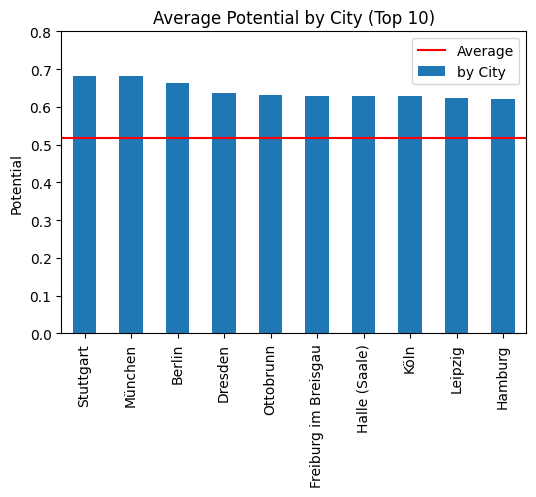

In [57]:
# compute the average
avg_city = top_neighborhoods[['city', 'potential']].groupby(by='city').agg('mean').values.mean()

# plotting the graph
top_neighborhoods[['city', 'potential']].groupby(by='city').agg('mean').sort_values(by='potential', ascending=False).head(10).sort_values(by='potential', ascending=False).plot.bar()
plt.ylabel('Potential')
plt.xlabel('')
plt.title('Average Potential by City (Top 10)')
plt.axhline(y=avg_city, color='r', linestyle='-', label='Average')
plt.yticks(np.arange(0.0, 0.9, 0.1))
plt.legend().get_texts()[1].set_text('by City')
plt.show()

#### Ranking Regions by most high potential (>=0.7) locations

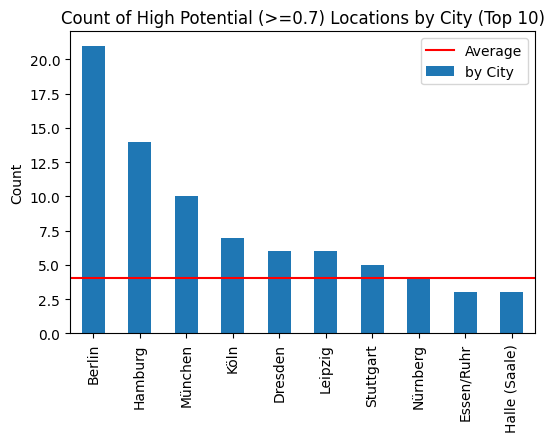

In [59]:
# computing the average
avg_count = top_neighborhoods.loc[top_neighborhoods.potential >= 0.7, 'city'].value_counts(ascending=True).values.mean()

# plotting the graph
top_neighborhoods.loc[top_neighborhoods.potential >= 0.7, 'city'].value_counts(ascending=False).head(10).plot.bar()
plt.title('Count of High Potential (>=0.7) Locations by City (Top 10)')
plt.ylabel('Count')
plt.axhline(y=avg_count, color='r', linestyle='-', label='Average')
plt.legend().get_texts()[1].set_text('by City')
plt.show()

#### Visualizing the Neighborhoods Potential as a HeatMap with Folium

In [370]:
# first define the function for the map

def simple_folium(df:pd.DataFrame, lat_col:str, lon_col:str, map_name:str):
    """
    Description
    ----------
        Returns a simple Folium HeatMap with Markers
    ----------
    Parameters
    ----------
        df : pandas DataFrame, required
            The DataFrane with the data to map
        lat_col : str, required
            The name of the column with latitude
        lon_col : str, required
            The name of the column with longitude
        map_name : Name of the Map :-)
    """

    # Preprocess

    # lat/lon to list & set type float
    df_locs = [[float(row['latitude']), float(row['longitude'])] for index, row in df.iterrows()]

    # Add the location name to the markers
    marker_info = []
    for tup in df.itertuples():
        marker = '<b>Quarter:</b> ' + str(tup.quarter) + '<br>' + \
                '<b>City:</b> ' + str(tup.city) + '<br>' + \
                '<b>Region:</b> ' + str(tup.region) + '<br>' + \
                '<b>Learn more:</b> ' + str(tup.wiki_url) + '<br>' + \
                '<b>Potential (0-1):</b> ' + str(round(tup.potential_norm, 2))
        marker_info.append(marker)
    marker_info

    #Set up folium map
    fol_map = folium.Map([51.1642292, 10.4541194], zoom_start=6)

    # plot heatmap
    heat_map = plugins.HeatMap(df_locs, name=map_name)
    fol_map.add_child(heat_map)

    # plot markers
    markers = plugins.MarkerCluster(locations = df_locs, popups = marker_info, name='Neighborhood')
    fol_map.add_child(markers)

    #Add Layer Control
    folium.LayerControl().add_to(fol_map)

    return fol_map

In [371]:
# take only the neighborhoods with potential of 0.70+
neighborhoods_potential_high = neighborhoods_potential[neighborhoods_potential.potential_norm >= 0.7]

# call the Folium function
simple_folium(df=neighborhoods_potential_high,
              lat_col='latitude',
              lon_col='longitude',
              map_name='Neighborhood_Potential')

## 9. Discussion & Outlook

### Discussion
Most of the leading locations have a high retail sparsity of above 90% of the maximum sparsity within the dataset. This has mainly two reasons:
First, the histograms of the KPIs show a clearly skewed distribution. While almost all the locations have a high retail sparsity (above 0.9 and nearly none below 0.7), the population density is more balanced, with most locations having 0.2 or lower, but the big cities having 0.8 and above. Therefore, cities with a high population density separate themselves from the rest, while retail sparsity has a much smaller range and is much more dense around 0.9, which leaves less space for improvement. The reason for the high average retail sparsity has methodological reasons and is discussed in 4.2.
The second reason is best explained with an example: In the Top 20 list of high potential locations the neighborhood “Berlin-Gropiusstadt” is on the 8th place with a high retail sparsity of 0.98. This is irritating because of the huge shopping mall “Gropius Passagen” that is within this neighborhood, but not within the dataset. This can occur a) when the API doesn’t list this mall or its stores, b) when the search radius was not large enough so it doesn’t cover the mall from the geocoded latitude/longitude position, or c) when the predefined venue categories don’t match the category of this specific mall. Since “Shopping Mall” is not listed within “Clothing Stores” as a venue category (see: https://developer.foursquare.com/docs/build-with-foursquare/categories/), option c) is highly possible.

The major point of discussion when it comes to data collection and data quality is the scraping of Wikipedia. If it was a “static” approach, like the scraping od the zipcodes, where the websites that have to be scraped are known, it would have been more controllable. But with this approach, every location had to be searched by the Wikipedia algorithm, triggered by the request that looped through the zipcode locations. The first hindrance was to get to the details page via the top result of the triggered search page. Even though there were several attempts tested by hand and the best method (zipcode plus name of the quarter as a search string) was chosen accordingly, there were some cases where the wrong data was scraped. An example is the city “Düsseldorf” with its different quarters. Even though the search string was best practice, the top result on Wikipedia wasn’t the city’s quarter, but the city itself and the wrong area and population was scraped. 

Another point of argument is the extremely high density and skewness of the retail sparsity histogram. The KPI is concentrated around a mean of 0.99 from a maximum of 1, which brings up questions on the usefulness of this metric. Retail sparsity is the invers of retail density (normalized), which itself is a measure for venues per square kilometer. The picture below illustrates the root cause. There are only two locations with a normalized retail density of 0.7 and above and they are so dense in venues, that every other location is retail sparse compared to this. Through normalization those extreme values were set to 1 (retail density) and every other value is a kind of percentage of that maximum, due to the formula of the normalization.

Last but not least was the radius to search for surrounding venues computed using the area that was scraped from Wikipedia. There problem is that the zipcode locations are not perfect circles, of course. The radius is therefore a best guess with the same area size as the location, but not the same form. Due to that fact there are probably some missing and some wrong venues attributed to an area.


### Outlook
This project tried to find regions within Germany that offer a high potential for E-Commerce companies and their marketing and sales efforts. The potential was defined by the population density and the retail sparsity, that were computed by using data from a zipcode locations website, Wikipedia and the Foursquare API.

Even though the dynamic scraping approach with Wikipedia was lacking some precision and therefore data quality / data veracity, the cleaned results can be viewed as the most up to date database on zipcode locations with area and population. The last national census in Germany was in 2011 and the data from the official government statistics website is therefore outdated. There was no other source than Wikipedia with such a vast and up to date knowledge on small villages, cities and their quarters.

The results show clearly that there is regional variance in potential and where E-Commerce companies can concentrate their activities to open up those areas. The results (like the Top 20 table) can be checked manually with the Wikipedia URL to obtain more and deeper insights about the prospect location and discuss possibilities. The most potent regions are summarized in an interactive Folium Heatmap that can help to get a first impression of the German landscape and the geographics, plus some basic information on the locations when clicking on the markers.

The results should be taken with a grain of salt, though. Especially the computation of potential and the normalization / standardization has room for improvement, as mentioned in the methodology discussion. Future research could try different approaches that are less skewed regarding retail density / sparsity to get a more realistic picture of the locations’ potential.

Future research could also use different venue category codes in the Foursquare API URI compared to just using “Clothing Stores” and its sub-categories. The problem with shopping malls, as mentioned in the results discussion. Those shopping malls could be a big difference in assessing the potential of a location, because they can host dozens of shops and therefore are a big contender aiming for fashion customers in this region.

Last but not least the attribution of venues to neighborhoods could be improved. Using a custom radius that is dependent on the area size is the best proxy so far, but maybe future Data Scientists find more appropriate ways like using the bounding boxes and a more sophisticated approach of geocoding.
The biggest possibility is the national census 2022 in Germany. This data will include area, population by age and gender and zipcode addresses that are the most accurate and up to date. Especially the demographic splits for the local population data are a huge opportunity for every retail companies, that can then tailor their definition of potential so sex and age and get a more accurate picture of the high potential regions.
